# Import Library

In [1]:
# Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
import shutil, os, glob, re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, to_date, to_timestamp, when, expr, date_trunc, count, avg, coalesce
from pyspark.sql.functions import explode, split, trim
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import count as Fcount
from pyspark.sql import Window
from pyspark.sql.functions import col, trim, upper, initcap

spark = SparkSession.builder \
    .appName("BNPL_Part1_Data") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/18 14:37:50 WARN Utils: Your hostname, xuzhengs-MacBook-Pro-2.local, resolves to a loopback address: 127.0.0.1; using 10.5.82.157 instead (on interface en0)
25/09/18 14:37:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/18 14:37:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Importing CSV
consumer_fraud = spark.read.csv("part1_data/consumer_fraud_probability.csv", 
                                header=True, inferSchema=True)

merchant_fraud = spark.read.csv("part1_data/merchant_fraud_probability.csv", 
                                header=True, inferSchema=True)



# Importing Parquet 
consumer_details = spark.read.parquet("part1_data/consumer_user_details.parquet")
tbl_merchants = spark.read.parquet("part1_data/tbl_merchants.parquet")

# Importing Shpile
SA2_PATH = "external_data/zone/AU_zone.shp"   # SA2 Shpile File (Map)
MIN_SAMPLES  = 5   


In [3]:
# Loading tbl_consumer
df = (spark.read
        .option("sep", "|")
        .option("header", True)
        .option("inferSchema", True)
        .csv("part1_data/tbl_consumer.csv"))

# Standardization of field content
df_std = (df
    .withColumn("name", trim(col("name")))
    .withColumn("address", trim(col("address")))
    .withColumn("state", upper(trim(col("state"))))     # Uniform capitalization
    .withColumn("gender", initcap(trim(col("gender"))))  
)

# Safely write standardized data
tmp_dir = "part1_data/__tmp_new_tbl_consumer"
out_csv = "part1_data/new_tbl_consumer.csv"

(df_std.coalesce(1)
   .write.mode("overwrite")
   .option("header", True)
   .option("encoding", "UTF-8")
   .csv(tmp_dir))

# Rename the output file
import os, glob, shutil
part = glob.glob(os.path.join(tmp_dir, "part-*.csv"))[0]
shutil.move(part, out_csv)
shutil.rmtree(tmp_dir)

# Reload the standardized CSV
new_tbl_consumer = (
    spark.read
         .option("header", True)      # 告诉 Spark 第一行是表头
         .option("sep", ",")          # 你在 part1 用 Spark 写出的 CSV 默认是逗号分隔
         .option("inferSchema", True) # 自动推断类型，方便后续 join
         .csv(out_csv)
)
new_tbl_consumer.show(5, truncate=False)
new_tbl_consumer.printSchema()

+-----------------+-----------------------------+-----+--------+------+-----------+
|name             |address                      |state|postcode|gender|consumer_id|
+-----------------+-----------------------------+-----+--------+------+-----------+
|Yolanda Williams |413 Haney Gardens Apt. 742   |WA   |6935    |Female|1195503    |
|Mary Smith       |3764 Amber Oval              |NSW  |2782    |Female|179208     |
|Jill Jones MD    |40693 Henry Greens           |NT   |862     |Female|1194530    |
|Lindsay Jimenez  |00653 Davenport Crossroad    |NSW  |2780    |Female|154128     |
|Rebecca Blanchard|9271 Michael Manors Suite 651|WA   |6355    |Female|712975     |
+-----------------+-----------------------------+-----+--------+------+-----------+
only showing top 5 rows
root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- consumer_id: intege

# Data Check - Part I

### Overview

In [4]:
# Show the initial data
# consumer_fraud: The fraud probability of a certain user placing an order at a certain time
consumer_fraud.show(10)
consumer_fraud.printSchema()

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
|   3101|    2021-04-17|91.42192091901347|
|  22239|    2021-10-19|94.70342477508035|
|  16556|    2022-02-20|89.65663294494827|
|  10278|    2021-09-28|83.59136689427714|
|  15790|    2021-12-30|71.77065889280253|
|   5233|    2021-08-29|85.87123303878818|
|    230|    2021-08-28|86.28328808934151|
+-------+--------------+-----------------+
only showing top 10 rows
root
 |-- user_id: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- fraud_probability: double (nullable = true)



In [5]:
# Show the initial data
# The fraud probability of a certain merchant's order
merchant_fraud.show(5)
merchant_fraud.printSchema()

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
| 82999039227|    2021-12-19|  94.1347004808891|
| 90918180829|    2021-09-02| 43.32551731714902|
+------------+--------------+------------------+
only showing top 5 rows
root
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- fraud_probability: double (nullable = true)



In [6]:
merchant_fraud.count()

114

In [7]:
# Show the initial data
# Basic demographic information of consumers
new_tbl_consumer.show(10)
new_tbl_consumer.printSchema()

+-----------------+--------------------+-----+--------+------+-----------+
|             name|             address|state|postcode|gender|consumer_id|
+-----------------+--------------------+-----+--------+------+-----------+
| Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|    1195503|
|       Mary Smith|     3764 Amber Oval|  NSW|    2782|Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|   NT|     862|Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|  NSW|    2780|Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|   WA|    6355|Female|     712975|
|    Karen Chapman|2706 Stewart Oval...|  NSW|    2033|Female|     407340|
|     Andrea Jones|   122 Brandon Cliff|  QLD|    4606|Female|     511685|
| Stephen Williams|6804 Wright Crest...|   WA|    6056|  Male|     448088|
|  Stephanie Reyes|5813 Denise Land ...|  NSW|    2482|Female|     650435|
| Jillian Gonzales|461 Ryan Common S...|  VIC|    3220|Female|    1058499|
+-----------------+------

In [8]:
# Show the initial data
# Use to convert and connect by user_id and consumer_id
consumer_details.show(5)
consumer_details.printSchema()

+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
|      3|    1194530|
|      4|     154128|
|      5|     712975|
+-------+-----------+
only showing top 5 rows
root
 |-- user_id: long (nullable = true)
 |-- consumer_id: long (nullable = true)



In [9]:
# Show the initial data
# The basic information of the merchant, including industry tags
tbl_merchants.show(10)
tbl_merchants.printSchema()

+--------------------+--------------------+------------+
|                name|                tags|merchant_abn|
+--------------------+--------------------+------------+
|       Felis Limited|((furniture, home...| 10023283211|
|Arcu Ac Orci Corp...|([cable, satellit...| 10142254217|
|    Nunc Sed Company|([jewelry, watch,...| 10165489824|
|Ultricies Digniss...|([wAtch, clock, a...| 10187291046|
| Enim Condimentum PC|([music shops - m...| 10192359162|
|       Fusce Company|[(gift, card, nov...| 10206519221|
|Aliquam Enim Inco...|[(computers, comP...| 10255988167|
|    Ipsum Primis Ltd|[[watch, clock, a...| 10264435225|
|Pede Ultrices Ind...|([computer progra...| 10279061213|
|           Nunc Inc.|[(furniture, home...| 10323485998|
+--------------------+--------------------+------------+
only showing top 10 rows
root
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- merchant_abn: long (nullable = true)



### Missing Values & Outliers

In [10]:
# Check Missing Values
results = {}
for df, name in [(consumer_fraud, "consumer_fraud"),
                 (merchant_fraud, "merchant_fraud"),
                 (new_tbl_consumer, "tbl_consumer"),
                 (consumer_details, "consumer_details"),
                 (tbl_merchants, "tbl_merchants")]:
    res = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns])\
            .groupBy().sum().collect()
    results[name] = res[0].asDict()

results

{'consumer_fraud': {'sum(user_id)': 0,
  'sum(order_datetime)': 0,
  'sum(fraud_probability)': 0},
 'merchant_fraud': {'sum(merchant_abn)': 0,
  'sum(order_datetime)': 0,
  'sum(fraud_probability)': 0},
 'tbl_consumer': {'sum(name)': 0,
  'sum(address)': 0,
  'sum(state)': 0,
  'sum(postcode)': 0,
  'sum(gender)': 0,
  'sum(consumer_id)': 0},
 'consumer_details': {'sum(user_id)': 0, 'sum(consumer_id)': 0},
 'tbl_merchants': {'sum(name)': 0, 'sum(tags)': 0, 'sum(merchant_abn)': 0}}

In [11]:
### Check the uniqueness of the primary key

# tbl_consumer check
new_tbl_consumer.select(countDistinct("consumer_id").alias("distinct_consumer_id")).show()
print("tbl_consumer total rows:", new_tbl_consumer.count())

# tbl_merchants check
tbl_merchants.select(countDistinct("merchant_abn").alias("distinct_merchant_abn")).show()
print("tbl_merchants total rows:", tbl_merchants.count())

# consumer_user_details check
consumer_details.select(countDistinct("user_id").alias("distinct_user_id")).show()
consumer_details.select(countDistinct("consumer_id").alias("distinct_consumer_id")).show()
print("consumer_details total rows:", consumer_details.count())

# user_id check
consumer_details.groupBy("user_id").count().orderBy("count", ascending=False).show(5)

# consumer_id check
consumer_details.groupBy("consumer_id").count().orderBy("count", ascending=False).show(5)

+--------------------+
|distinct_consumer_id|
+--------------------+
|              499999|
+--------------------+

tbl_consumer total rows: 499999
+---------------------+
|distinct_merchant_abn|
+---------------------+
|                 4026|
+---------------------+

tbl_merchants total rows: 4026
+----------------+
|distinct_user_id|
+----------------+
|          499999|
+----------------+

+--------------------+
|distinct_consumer_id|
+--------------------+
|              499999|
+--------------------+

consumer_details total rows: 499999
+-------+-----+
|user_id|count|
+-------+-----+
|     26|    1|
|    321|    1|
|     41|    1|
|    327|    1|
|     29|    1|
+-------+-----+
only showing top 5 rows
+-----------+-----+
|consumer_id|count|
+-----------+-----+
|     367113|    1|
|     845767|    1|
|    1174371|    1|
|      44111|    1|
|    1255411|    1|
+-----------+-----+
only showing top 5 rows


In [12]:
### Field type and value range correction

# Uniform time type
consumer_fraud  = consumer_fraud.withColumn("order_date", to_date(col("order_datetime")))
merchant_fraud  = merchant_fraud.withColumn("order_date", to_date(col("order_datetime")))

# fraud_probability range limit: [0, 100]
for df_name, df in [("consumer_fraud", consumer_fraud), ("merchant_fraud", merchant_fraud)]:
    bad_low  = df.filter(col("fraud_probability") < 0).count()
    bad_high = df.filter(col("fraud_probability") > 100).count()
    print(df_name, "low<0:", bad_low, "high>100:", bad_high)

# Create an "Exception Label" field for both consumer and merchant
consumer_fraud = consumer_fraud.withColumn(
    "is_prob_out_of_range",
    when((col("fraud_probability") < 0) | (col("fraud_probability") > 100), 1).otherwise(0)
)
merchant_fraud = merchant_fraud.withColumn(
    "is_prob_out_of_range",
    when((col("fraud_probability") < 0) | (col("fraud_probability") > 100), 1).otherwise(0)
)

consumer_fraud low<0: 0 high>100: 0
merchant_fraud low<0: 0 high>100: 0


### Distribution Check

In [13]:
### Show Fraud Probability

def prob_summary(df, colname="fraud_probability"):
    return df.selectExpr(
        f"min({colname}) as min",
        f"percentile_approx({colname}, 0.05) as p05",
        f"percentile_approx({colname}, 0.25) as p25",
        f"percentile_approx({colname}, 0.50) as median",
        f"avg({colname}) as mean",
        f"percentile_approx({colname}, 0.75) as p75",
        f"percentile_approx({colname}, 0.95) as p95",
        f"max({colname}) as max"
    )

print("== consumer_fraud =="); prob_summary(consumer_fraud).show()
print("== merchant_fraud =="); prob_summary(merchant_fraud).show()

== consumer_fraud ==
+-----------------+----------------+----------------+------------------+------------------+------------------+------------------+-----------------+
|              min|             p05|             p25|            median|              mean|               p75|               p95|              max|
+-----------------+----------------+----------------+------------------+------------------+------------------+------------------+-----------------+
|8.287143531552802|8.51799998867597|9.63404401745533|11.735485430281175|15.120090644154585|16.213757783429045|34.346776609318646|99.24738020302328|
+-----------------+----------------+----------------+------------------+------------------+------------------+------------------+-----------------+

== merchant_fraud ==
+-----------------+-----------------+-----------------+----------------+------------------+------------------+-----------------+----------------+
|              min|              p05|              p25|          median

Consumer rows: 34864, Merchant rows: 114


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


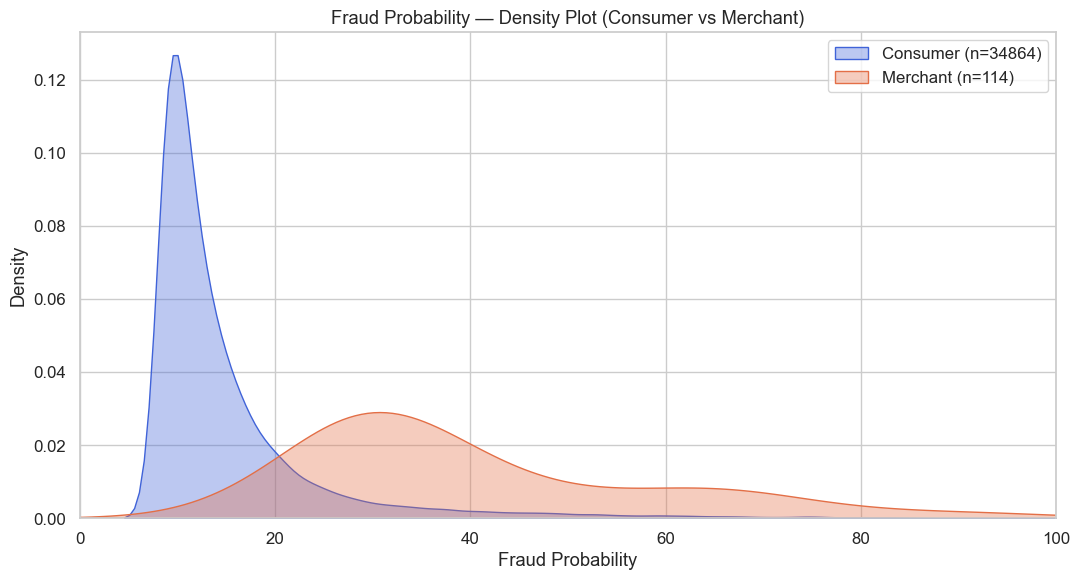

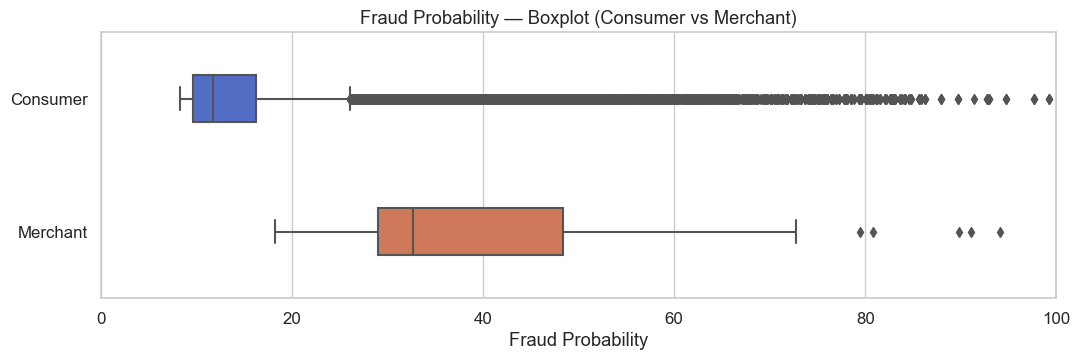

In [14]:
### Fraud Probability Visualisation

# Extract All data in the form of Pandas
cf_pd = (consumer_fraud
         .select(col("fraud_probability").cast("double").alias("fraud_probability"))
         .toPandas())
mf_pd = (merchant_fraud
         .select(col("fraud_probability").cast("double").alias("fraud_probability"))
         .toPandas())

# Basic cleaning: Remove possible NaN/ illegal values and uniformly crop them to [0,100]
cf_pd = cf_pd.replace([np.inf, -np.inf], np.nan).dropna()
mf_pd = mf_pd.replace([np.inf, -np.inf], np.nan).dropna()
cf_pd["fraud_probability"] = cf_pd["fraud_probability"].clip(0, 100)
mf_pd["fraud_probability"] = mf_pd["fraud_probability"].clip(0, 100)

print(f"Consumer rows: {len(cf_pd)}, Merchant rows: {len(mf_pd)}")

# Unify the plotting style
sns.set(style="whitegrid", font_scale=1.1)
x_min, x_max = 0, 100

# KDE Density Plot 
plt.figure(figsize=(11,6))

# Plot the Consumer fraud rate
sns.kdeplot(
    data=cf_pd,
    x="fraud_probability",
    fill=True, common_norm=False,
    color="#4063D8", alpha=0.35,
    bw_adjust=1.0,                      
    label=f"Consumer (n={len(cf_pd)})"
)

# Plot the Merchant fraud rate
sns.kdeplot(
    data=mf_pd,
    x="fraud_probability",
    fill=True, common_norm=False,
    color="#E36F47", alpha=0.35,
    bw_adjust=1.3,
    label=f"Merchant (n={len(mf_pd)})"
)

plt.xlim(x_min, x_max)
plt.xlabel("Fraud Probability")
plt.ylabel("Density")
plt.title("Fraud Probability — Density Plot (Consumer vs Merchant)")
plt.legend()
plt.tight_layout()
plt.show()

# Box plot (View median and tail)
plt.figure(figsize=(11,3.8))
sns.boxplot(
    data=pd.DataFrame({
        "Consumer": cf_pd["fraud_probability"],
        "Merchant": mf_pd["fraud_probability"]
    }),
    orient="h",
    palette=["#4063D8", "#E36F47"],
    width=0.35
)
plt.xlim(x_min, x_max)
plt.xlabel("Fraud Probability")
plt.title("Fraud Probability — Boxplot (Consumer vs Merchant)")
plt.tight_layout()
plt.show()


In [15]:
### Look at the magnitude and average risk by time (month)

cf_month = (consumer_fraud
            .withColumn("month", date_trunc("month", col("order_date")))
            .groupBy("month")
            .agg(count("*").alias("n_txn"),
                 avg("fraud_probability").alias("avg_prob"))
            .orderBy("month"))
cf_month.show(12, truncate=False)

mf_month = (merchant_fraud
            .withColumn("month", date_trunc("month", col("order_date")))
            .groupBy("month")
            .agg(count("*").alias("n_txn"),
                 avg("fraud_probability").alias("avg_prob"))
            .orderBy("month"))
mf_month.show(12, truncate=False)

+-------------------+-----+------------------+
|month              |n_txn|avg_prob          |
+-------------------+-----+------------------+
|2021-02-01 00:00:00|18   |15.891153513870623|
|2021-03-01 00:00:00|539  |14.686233949236382|
|2021-04-01 00:00:00|571  |14.605609077107525|
|2021-05-01 00:00:00|666  |14.842259160438802|
|2021-06-01 00:00:00|655  |14.228753068906279|
|2021-07-01 00:00:00|750  |14.725419354515335|
|2021-08-01 00:00:00|1256 |15.271882727231446|
|2021-09-01 00:00:00|4520 |15.120578016391924|
|2021-10-01 00:00:00|4917 |15.30227000413199 |
|2021-11-01 00:00:00|7133 |15.046375701890268|
|2021-12-01 00:00:00|6861 |15.026077263616688|
|2022-01-01 00:00:00|3670 |15.349828952019694|
+-------------------+-----+------------------+
only showing top 12 rows
+-------------------+-----+------------------+
|month              |n_txn|avg_prob          |
+-------------------+-----+------------------+
|2021-03-01 00:00:00|1    |69.08556869902988 |
|2021-04-01 00:00:00|1    |32.99497

### Correlation Check

In [16]:
### Connect consumer profiles such as state, gender and risk

# user_id -> consumer_id -> tbl_consumer
cf_joined = (consumer_fraud
             .join(consumer_details, "user_id", "left")
             .join(new_tbl_consumer, "consumer_id", "left"))

# The average fraud probability by state/gender and the sample size
cf_by_state  = cf_joined.groupBy("state").agg(avg("fraud_probability").alias("avg_prob"),
                                              count("*").alias("n")).orderBy(col("avg_prob").desc())
cf_by_gender = cf_joined.groupBy("gender").agg(avg("fraud_probability").alias("avg_prob"),
                                               count("*").alias("n")).orderBy(col("avg_prob").desc())

cf_by_state.show(truncate=False)
cf_by_gender.show(truncate=False)

+-----+------------------+-----+
|state|avg_prob          |n    |
+-----+------------------+-----+
|TAS  |15.384440242109859|1332 |
|NT   |15.308708799890276|480  |
|QLD  |15.27782060075581 |5109 |
|VIC  |15.162124631050196|8129 |
|SA   |15.144591238945795|3926 |
|NSW  |15.13376173146009 |10037|
|WA   |14.831025833813962|5538 |
|ACT  |14.408422510779635|313  |
+-----+------------------+-----+

+-----------+------------------+-----+
|gender     |avg_prob          |n    |
+-----------+------------------+-----+
|Undisclosed|15.27125840758897 |3580 |
|Male       |15.210206353750316|15739|
|Female     |14.994036495140978|15545|
+-----------+------------------+-----+



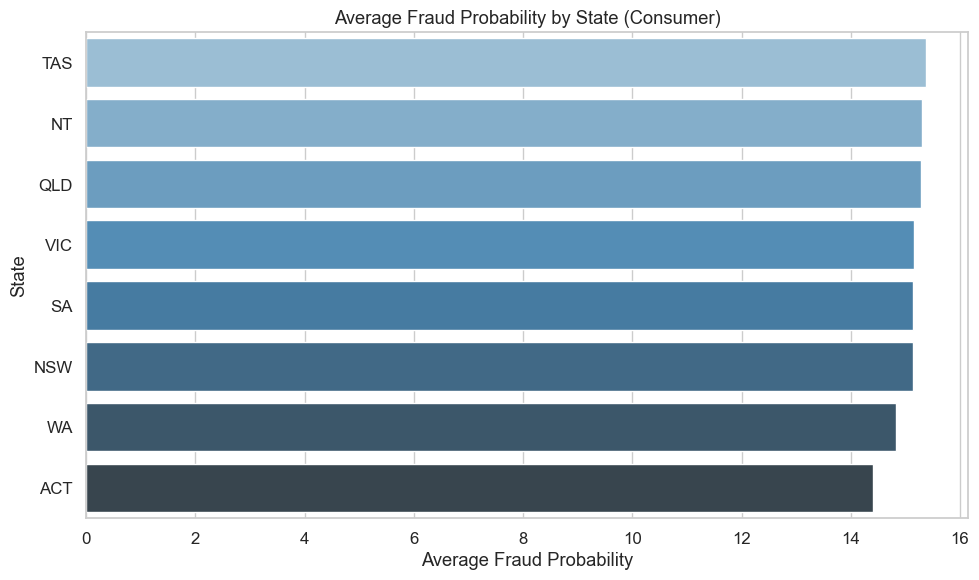

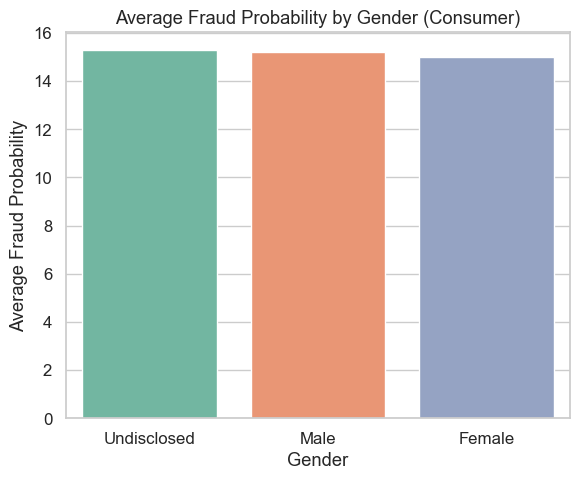

In [17]:
### Visualize fraud probability and other correlations

# Switch to Pandas
cf_by_state_pd = cf_by_state.toPandas()
cf_by_gender_pd = cf_by_gender.toPandas()

# Set a unified style
sns.set(style="whitegrid", font_scale=1.1)

# Average Fraud Probability by State
plt.figure(figsize=(10,6))
sns.barplot(
    data=cf_by_state_pd.sort_values("avg_prob", ascending=False),
    x="avg_prob", y="state",
    palette="Blues_d"
)
plt.xlabel("Average Fraud Probability")
plt.ylabel("State")
plt.title("Average Fraud Probability by State (Consumer)")
plt.tight_layout()
plt.show()

# Average Fraud Probability by Gender
plt.figure(figsize=(6,5))
sns.barplot(
    data=cf_by_gender_pd.sort_values("avg_prob", ascending=False),
    x="gender", y="avg_prob",
    palette="Set2"
)
plt.xlabel("Gender")
plt.ylabel("Average Fraud Probability")
plt.title("Average Fraud Probability by Gender (Consumer)")
plt.tight_layout()
plt.show()

In [18]:
### Check the weight of the gender category

# Unify the gender writing style for statistical purposes only
gender_stat = (
    new_tbl_consumer
    .withColumn(
        "gender_norm",
        F.when(F.lower(F.col("gender")).isin("male","m"), "Male")
         .when(F.lower(F.col("gender")).isin("female","f"), "Female")
         .otherwise("Undisclosed")    # Including null values/unknown/others
    )
    .groupBy("gender_norm")
    .agg(F.count("*").alias("n"))
)

total_n = gender_stat.agg(F.sum("n")).first()[0]

gender_stat = (
    gender_stat
    .withColumn("pct", F.round(F.col("n")/F.lit(total_n)*100, 2))
    .orderBy(F.desc("n"))
)

gender_stat.show(truncate=False)
print(f"Total rows: {total_n}")

+-----------+------+-----+
|gender_norm|n     |pct  |
+-----------+------+-----+
|Male       |224979|45.0 |
|Female     |224946|44.99|
|Undisclosed|50074 |10.01|
+-----------+------+-----+

Total rows: 499999


In [19]:
### Connect merchant Profile -> Industry Tags and Risks

# Check the type of tags 
print(tbl_merchants.schema["tags"].dataType)

# Uniformly expand tags
if isinstance(tbl_merchants.schema["tags"].dataType, ArrayType):
    # if tag is array: explore
    merchants_exploded = (
        tbl_merchants
        .select("merchant_abn", F.explode_outer("tags").alias("tag_raw"))
    )
else:
    # if tag is string: clean + split + explode
    merchants_exploded = (
        tbl_merchants
        .withColumn("tags_str", F.coalesce(F.col("tags").cast("string"), F.lit("")))
        # Remove the common parenthesis symbols
        .withColumn("tags_clean", F.regexp_replace("tags_str", r"[\[\]\(\)]", ""))
        # Unify common delimiters as commas (retain/expand as needed)
        .withColumn("tags_clean", F.regexp_replace("tags_clean", r"[;/]+", ","))
        # Divide by commas and expand
        .withColumn("tag_raw", F.explode_outer(F.split(F.col("tags_clean"), r"\s*,\s*")))
    )

# Standardized tags: Remove Spaces, convert to lowercase, remove empty strings
merchants_exploded = (
    merchants_exploded
    .withColumn("tag", F.trim(F.lower(F.col("tag_raw"))))
    .filter(F.col("tag").isNotNull() & (F.col("tag") != ""))
    .select("merchant_abn", "tag")
)

# The probability of fraud by associated merchants
mf_joined = merchant_fraud.join(merchants_exploded, "merchant_abn", "left")

# Calculate the sample size and average fraud probability of each tag
mf_by_tag = (mf_joined
             .groupBy("tag")
             .agg(F.count("*").alias("n"),
                  F.avg("fraud_probability").alias("avg_prob"))
             .filter(F.col("n") >= 5)          
             .orderBy(F.col("avg_prob").desc()))

mf_by_tag.show(50, truncate=False)

StringType()
+------------------------------------+---+------------------+
|tag                                 |n  |avg_prob          |
+------------------------------------+---+------------------+
|NULL                                |19 |44.929074633541305|
|home furnishings and equipment shops|5  |44.62062407904109 |
|furniture                           |5  |44.62062407904109 |
|except appliances                   |5  |44.62062407904109 |
|and manufacturers                   |5  |44.62062407904109 |
|a                                   |18 |41.2530652860964  |
|c                                   |20 |40.159028844542576|
|watch                               |23 |39.730783915430486|
|clock                               |23 |39.730783915430486|
|jewelry                             |22 |38.65594029125101 |
|and silverware shops                |22 |38.65594029125101 |
|antique shops - sales               |26 |38.01143524197595 |
|and restoration services            |26 |38.011435241975

In [20]:
# Check a few of the longest tags to confirm their composition
(
  tbl_merchants
  .select("name","merchant_abn","tags", F.length("tags").alias("len"))
  .orderBy(F.desc("len"))
  .show(10, truncate=False)
)

# Look at the representatives of different tag styles
tbl_merchants.select("tags").distinct().orderBy(F.length("tags").desc()).show(50, truncate=False)

tbl_merchants.select("merchant_abn","tags").limit(5).toPandas()

+------------------------------+------------+-------------------------------------------------------------------------------------------------------------------+---+
|name                          |merchant_abn|tags                                                                                                               |len|
+------------------------------+------------+-------------------------------------------------------------------------------------------------------------------+---+
|Aliquam Arcu Industries       |71787414647 |((furniture, home FurnishIngs and  equipment shops,  and manufacturers, except appliances), (a), (take rate: 6.05))|115|
|Congue Corporation            |15612785317 |[(furniture, home furnishinGs and equiPment shops, and  manufacturers, except appliances), (a), (take rate: 6.99)] |114|
|Sed Leo Cras Industries       |65175701530 |[[furniture, home furnishings and equipment  shops, and manufacturers, except appliances], [a], [take rate: 5.64]] |114|
|Est

,merchant_abn,tags
0,10023283211,"((furniture, home furnishings and equipment sh..."
1,10142254217,"([cable, satellite, and otHer pay television a..."
2,10165489824,"([jewelry, watch, clock, and silverware shops]..."
3,10187291046,"([wAtch, clock, and jewelry repair shops], [b]..."
4,10192359162,"([music shops - musical instruments, pianos, a..."


In [21]:
tbl_merchants.count()

4026

In [22]:
### Check Abnormal Value 
dup_cf = (consumer_fraud
          .groupBy("user_id","order_date")
          .agg(Fcount("*").alias("n"))
          .where("n>1")
          .count())
dup_mf = (merchant_fraud
          .groupBy("merchant_abn","order_date")
          .agg(Fcount("*").alias("n"))
          .where("n>1")
          .count())
print("duplicate (user_id, order_date):", dup_cf)
print("duplicate (merchant_abn, order_date):", dup_mf)

duplicate (user_id, order_date): 99
duplicate (merchant_abn, order_date): 0


# Data Cleaning

### tbl_consumer

In [23]:
### tbl_consumer的gender: Undisclosed (weight = 10%)
new_tbl_consumer = (
    new_tbl_consumer
    .withColumn(
        "gender",
        F.when(F.lower(F.col("gender")).isin("male", "m"), "Male")
         .when(F.lower(F.col("gender")).isin("female", "f"), "Female")
         .otherwise("Other")   
    )
)


### tbl_merchants

In [24]:
# Uniform lowercase
m1 = tbl_merchants.withColumn("tags_lc", F.lower(F.col("tags")))

# Remove 'take rate: x.xx' and possible outer parentheses, commas before and after, and Spaces
m2 = m1.withColumn(
    "tags_no_tr",
    F.regexp_replace(
        F.col("tags_lc"),
        r"\(?\s*take\s*rate\s*:\s*\d+(\.\d+)?\s*\)?\s*,?",  
        ""
    )
)

# Remove all parentheses, square brackets and double brackets, and press all kinds of blanks into single Spaces
m3 = (m2
    .withColumn("tags_no_br", F.regexp_replace("tags_no_tr", r"[\[\]\(\)]", " "))
    .withColumn("tags_sp",   F.regexp_replace("tags_no_br",  r"\s+", " "))     
    .withColumn("tags_norm", F.trim(F.regexp_replace("tags_sp", r"\s*,\s*", ",")))
)

m3.show(10, truncate=False)

+------------------------------------+-----------------------------------------------------------------------------------------------------------------+------------+-----------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+
|name                                |tags                                                                                                             |merchant_abn|tags_lc                                                                                                          |tags_no_tr                                                         

In [25]:
# Split by comma, explode to rows
m_tokens = (m3
    .withColumn("tag_arr",  F.split(F.col("tags_norm"), r","))
    .withColumn("tag_token", F.explode(F.col("tag_arr")))
    .withColumn("tag_token", F.trim(F.col("tag_token")))
)

# Filter out obvious noise: empty strings, single letters, pure numbers/pure decimals
m_tokens_clean = (m_tokens
    .filter(F.col("tag_token") != "")
    .filter(~F.col("tag_token").rlike(r"^[a-z]$"))             
    .filter(~F.col("tag_token").rlike(r"^\d+(\.\d+)?$"))      
)

m_tokens_clean = (m_tokens_clean
    .filter(F.col("name").isNotNull())
)

m_tokens_clean.show(10, truncate=False)

+------------------------+-----------------------------------------------------------------------------------------------------------------+------------+-----------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------+-------------------------------------------+
|name                    |tags                                                                                                             |merchant_abn|tags_lc                                                             

In [26]:
# Each merchant aggregates the de-duplicated tokens and reassembles them into a standardized string
merchant_base = tbl_merchants.select("merchant_abn", "name")

tbl_merchants_clean = (
    m_tokens_clean
      .groupBy("merchant_abn")
      .agg(
          F.first("name").alias("name"),
          F.array_sort(F.array_distinct(F.collect_list("tag_token"))).alias("tag_tokens")
      )
      .withColumn("tags_clean", F.array_join(F.col("tag_tokens"), ", "))
      .select("name", "merchant_abn", "tag_tokens", "tags_clean")
)

# Show the cleaned result
tbl_merchants_clean.show(20, truncate=False)

+------------------------------------+------------+---------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+
|name                                |merchant_abn|tag_tokens                                                                             |tags_clean                                                                           |
+------------------------------------+------------+---------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+
|Felis Limited                       |10023283211 |[and manufacturers, except appliances, furniture, home furnishings and equipment shops]|and manufacturers, except appliances, furniture, home furnishings and equipment shops|
|Arcu Ac Orci Corporation            |10142254217 |[and other pay television and radio services,

In [27]:
tbl_merchants_clean.count()

4026

In [ ]:
# Take a look at the top 50 token frequencies to help you determine the Layer 2 mapping vocabulary
token_freq = (m_tokens_clean
    .groupBy("tag_token").count()
    .orderBy(F.desc("count"))
)

token_freq.show(100, truncate=False)

+----------------------------------------------+-----+
|tag_token                                     |count|
+----------------------------------------------+-----+
|furniture                                     |316  |
|watch                                         |261  |
|clock                                         |261  |
|digital goods: books                          |195  |
|music                                         |195  |
|movies                                        |195  |
|artist supply and craft shops                 |193  |
|and integrated systems design services        |191  |
|data processing                               |191  |
|computer programming                          |191  |
|shoe shops                                    |185  |
|and souvenir shops                            |182  |
|novelty                                       |182  |
|home furnishings and equipment shops          |182  |
|card                                          |182  |
|except ap

In [46]:
tbl_merchants_clean = tbl_merchants_clean.drop("tags_tokens")
tbl_merchants_clean.show(30, truncate=False)


+------------------------------------+------------+---------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+
|name                                |merchant_abn|tag_tokens                                                                             |tags_clean                                                                           |
+------------------------------------+------------+---------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+
|Felis Limited                       |10023283211 |[and manufacturers, except appliances, furniture, home furnishings and equipment shops]|and manufacturers, except appliances, furniture, home furnishings and equipment shops|
|Arcu Ac Orci Corporation            |10142254217 |[and other pay television and radio services,

In [47]:
# Create the tag dictionary
tag_category_map = {
    # Home furnishings/furniture category
    "furniture": "Home & Furniture",
    "home furnishings": "Home & Furniture",
    "equipment shops": "Home & Furniture",
    "manufacturers": "Home & Furniture",
    "appliances": "Home & Furniture",   

    # Electrical appliances/small household appliances category
    "except appliances": "Small Appliances", 

    # Musical Instruments/cultural and entertainment category
    "music shops": "Culture & Entertainment",
    "sheet music": "Culture & Entertainment",
    "pianos": "Culture & Entertainment",
    "musical instruments": "Culture & Entertainment",

    # Jewelry/luxury goods category
    "jewelry": "Jewellery & Watches",
    "jewellery": "Jewellery & Watches",
    "watch": "Jewellery & Watches",
    "clock": "Jewellery & Watches",
    "silverware": "Jewellery & Watches",

    # Gifts/commemorative items
    "souvenir": "Gifts & Novelties",
    "gift": "Gifts & Novelties",
    "card": "Gifts & Novelties",
    "novelty": "Gifts & Novelties",

    # Software/IT/telecommunications category
    "software": "Software & IT",
    "data processing": "Software & IT",
    "computer": "Software & IT",
    "telecom": "Telecom",
    "telecommunications": "Telecom",
    "mobile": "Telecom",

    # Handicrafts/flowers 
    "artist supply": "Crafts & Flowers",
    "craft shops": "Crafts & Flowers",
    "florists": "Crafts & Flowers",
    "nursery stock": "Crafts & Flowers",

    # Maintenance/leasing category
    "repair": "Repair & Leasing",
    "appliance rent": "Repair & Leasing",
    "leasing": "Repair & Leasing",
    "tool": "Repair & Leasing",

    # Automotive
    "motor vehicle": "Automotive",
    "new parts": "Automotive"
}

# Map the token to the major category
def _map_category(token: str):
    if token is None:
        return None
    s = token.lower()
    for k, v in tag_category_map.items():
        if k in s:    
            return v
    return None          # if cannot be map, use Other

map_category_udf = F.udf(_map_category, "string")

In [48]:
# Split the tags_clean word, standardize it and map it to the major category
tokens_df = (
    tbl_merchants_clean
      .select("merchant_abn", "tags_clean")
      .withColumn("tok_arr", F.split(F.col("tags_clean"), ","))          # Comma separated
      .withColumn("tok", F.explode("tok_arr"))                           # Split
      .withColumn("tok", F.trim(F.lower(F.col("tok"))))                  # Unify lowercase letters without Spaces
      .filter(F.col("tok") != "")                                        # Delete the empty
      .withColumn("tag_category", map_category_udf(F.col("tok")))        # Mapping major classes
      .withColumn("tag_category", F.when(F.col("tag_category").isNull(), F.lit("Other"))
                                   .otherwise(F.col("tag_category")))
      .select("merchant_abn", "tag_category")
      .dropDuplicates()                                                  # Remove duplicates from each merchant and each category
)

In [49]:
# Count the occurrence frequency of each merchant in each major category and sort/rank them
cat_counts = (
    tokens_df
      .groupBy("merchant_abn", "tag_category")
      .agg(F.count(F.lit(1)).alias("n"))
      .withColumn("is_other", F.when(F.col("tag_category") == "Other", F.lit(1)).otherwise(F.lit(0)))
)

# Sorting strategy: In descending order of occurrence frequency; In the same number of times, non-other takes priority. Then, in ascending order by category name
w = Window.partitionBy("merchant_abn").orderBy(
        F.desc("n"),
        F.asc("is_other"),
        F.asc("tag_category")
    )

ranked = cat_counts.withColumn("rk", F.row_number().over(w))

top1 = (
    ranked
      .filter(F.col("rk") == 1)
      .select("merchant_abn", F.col("tag_category").alias("tag_category_top"))
)

In [50]:
# Write back to the merchant table
tbl_merchants_enriched = (
    tbl_merchants_clean
        .join(top1, "merchant_abn", "left")
)

tbl_merchants_enriched = tbl_merchants_enriched.filter(F.col("tag_category_top").isNotNull())


# Show the result
tbl_merchants_enriched.select(
    "name", "merchant_abn", "tag_category_top"
).show(10, truncate=False)

+------------------------------------+------------+-----------------------+
|name                                |merchant_abn|tag_category_top       |
+------------------------------------+------------+-----------------------+
|Felis Limited                       |10023283211 |Home & Furniture       |
|Arcu Ac Orci Corporation            |10142254217 |Other                  |
|Nunc Sed Company                    |10165489824 |Jewellery & Watches    |
|Ultricies Dignissim Lacus Foundation|10187291046 |Jewellery & Watches    |
|Enim Condimentum PC                 |10192359162 |Culture & Entertainment|
|Fusce Company                       |10206519221 |Gifts & Novelties      |
|Aliquam Enim Incorporated           |10255988167 |Software & IT          |
|Ipsum Primis Ltd                    |10264435225 |Jewellery & Watches    |
|Pede Ultrices Industries            |10279061213 |Software & IT          |
|Nunc Inc.                           |10323485998 |Home & Furniture       |
+-----------

In [51]:
tbl_merchants_enriched.count()

4026

In [52]:
tbl_merchants_enriched.show(10)

+------------+--------------------+--------------------+--------------------+--------------------+
|merchant_abn|                name|          tag_tokens|          tags_clean|    tag_category_top|
+------------+--------------------+--------------------+--------------------+--------------------+
| 10023283211|       Felis Limited|[and manufacturer...|and manufacturers...|    Home & Furniture|
| 10142254217|Arcu Ac Orci Corp...|[and other pay te...|and other pay tel...|               Other|
| 10165489824|    Nunc Sed Company|[and silverware s...|and silverware sh...| Jewellery & Watches|
| 10187291046|Ultricies Digniss...|[and jewelry repa...|and jewelry repai...| Jewellery & Watches|
| 10192359162| Enim Condimentum PC|[and sheet music,...|and sheet music, ...|Culture & Enterta...|
| 10206519221|       Fusce Company|[and souvenir sho...|and souvenir shop...|   Gifts & Novelties|
| 10255988167|Aliquam Enim Inco...|[and software, co...|and software, com...|       Software & IT|
| 10264435

# Join Table

### Consumer Level 

##### consumer_fraud + consumer_details + tbl_consumer

In [53]:
### Consumer level join 

# Type/Column processing
cf = (
    consumer_fraud
    .withColumn("order_date", to_date(col("order_datetime")))  
    .withColumn("c_fraud_prob", col("fraud_probability").cast("double"))  # rename the fraud column
    .drop("fraud_probability")  # delete the old column
)

# user_id -> consumer_id (Deduplication: If user_id maps multiple Consumerids, only one is retained)
cd = (
    consumer_details
    .select("user_id", "consumer_id")
    .dropDuplicates(["user_id"])  
)

# User profile (To avoid column conflicts, prefix the profile field with "c_")
tc = (
    new_tbl_consumer
    .select(
        col("consumer_id"),
        col("state").alias("c_state"),
        col("postcode").alias("c_postcode"),
        col("gender").alias("c_gender"),
    )
)

# left join: Transaction mapping portrait in sequence
consumer_joined = (
    cf.alias("cf")
      .join(cd.alias("cd"), on="user_id", how="left")
      .join(tc.alias("tc"), on="consumer_id", how="left")
)

# Preview the result
print(">>> consumer_joined preview")
consumer_joined.select("user_id", "consumer_id", "order_date", "c_fraud_prob", "c_state", "c_postcode", "c_gender").show(5, truncate=False)
consumer_joined.printSchema()

consumer_level = consumer_joined.filter(col("consumer_id").isNull()).count()
print(f"[Check] consumer_id is NULL after join: {consumer_level}")



>>> consumer_joined preview
+-------+-----------+----------+-----------------+-------+----------+--------+
|user_id|consumer_id|order_date|c_fraud_prob     |c_state|c_postcode|c_gender|
+-------+-----------+----------+-----------------+-------+----------+--------+
|21419  |10448      |2021-12-10|99.24738020302328|QLD    |4003      |Female  |
|6228   |1242133    |2021-12-19|97.6298077657765 |VIC    |3186      |Male    |
|22239  |184299     |2021-10-19|94.70342477508035|VIC    |3813      |Male    |
|5606   |882166     |2021-10-17|84.05825045251777|QLD    |4454      |Other   |
|16556  |1243659    |2022-02-20|89.65663294494827|QLD    |4743      |Male    |
+-------+-----------+----------+-----------------+-------+----------+--------+
only showing top 5 rows
root
 |-- consumer_id: long (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_date: date (nullable = true)
 |-- is_prob_out_of_range: integer (nullable = false)
 |-- c_fraud_

In [54]:
# Select the "No Time" field you need to keep and name it uniformly in lowercase
consumer_profile = (
    consumer_joined
    .select(
        F.col("user_id").alias("c_user_id"),
        F.col("consumer_id").alias("consumer_id"),
        F.col("c_fraud_prob").alias("c_fraud_prob"),
        F.col("c_state")
    )
    .dropDuplicates(["consumer_id"])       
)

# Save the file and output
out_path = "part1_data/consumer_profile.parquet"
consumer_profile.write.mode("overwrite").parquet(out_path)

print(f"consumer_profile saved to: {out_path}")
consumer_profile.show(5, truncate=False)
print("rows:", consumer_profile.count())

consumer_profile saved to: part1_data/consumer_profile.parquet
+---------+-----------+------------------+-------+
|c_user_id|consumer_id|c_fraud_prob      |c_state|
+---------+-----------+------------------+-------+
|13842    |30         |16.709045232443952|VIC    |
|15373    |105        |12.319746480481419|NSW    |
|5162     |226        |8.91637740763569  |SA     |
|2979     |257        |12.305320973481981|VIC    |
|22602    |438        |12.319612170395782|NSW    |
+---------+-----------+------------------+-------+
only showing top 5 rows
rows: 20128


In [55]:
# Save consumer_joined
consumer_path = "part1_data/consumer_profile.parquet"
consumer_profile.write.mode("overwrite").parquet(consumer_path)
print(f"Consumer profile saved to {consumer_path}")

Consumer profile saved to part1_data/consumer_profile.parquet


### Merchant Level 

##### merchant_fraud_probability + tbl_merchants

In [56]:
# Clean the fraud probability table
mf = (
    merchant_fraud
    .withColumn("order_date", F.to_date("order_datetime"))
    .withColumn("m_fraud_prob", F.col("fraud_probability").cast("double"))
    .drop("fraud_probability")
)

# Clean the merchant meta table
m_base = tbl_merchants_enriched.alias("m")  

m_name = (
    tbl_merchants_enriched
    .select(
        F.col("merchant_abn").alias("merchant_abn"),
        F.col("name").alias("m_name"),
        F.col("tag_category_top").alias("m_category")
    )
)

# The left link ensures that all merchants retain it
merchant_joined = (
    m_base
    .join(m_name, on="merchant_abn", how="left")   # Ensure that all merchants have meta information
    .join(mf, on="merchant_abn", how="left")      # Then connect "fraud probability"
)

# Preview
merchant_joined.select(
    "merchant_abn", "m_name", "m_category", "order_date", "m_fraud_prob"
).show(20, truncate=False)

# Count the total number of merchants
print("[Total number of merchants]:", merchant_joined.select("merchant_abn").distinct().count())

+------------+------------------------------------+-----------------------+----------+------------+
|merchant_abn|m_name                              |m_category             |order_date|m_fraud_prob|
+------------+------------------------------------+-----------------------+----------+------------+
|10023283211 |Felis Limited                       |Home & Furniture       |NULL      |NULL        |
|10142254217 |Arcu Ac Orci Corporation            |Other                  |NULL      |NULL        |
|10165489824 |Nunc Sed Company                    |Jewellery & Watches    |NULL      |NULL        |
|10187291046 |Ultricies Dignissim Lacus Foundation|Jewellery & Watches    |NULL      |NULL        |
|10192359162 |Enim Condimentum PC                 |Culture & Entertainment|NULL      |NULL        |
|10206519221 |Fusce Company                       |Gifts & Novelties      |NULL      |NULL        |
|10255988167 |Aliquam Enim Incorporated           |Software & IT          |NULL      |NULL        |


In [57]:
# Check if there is NULL in m_category
null_category_count = merchant_joined.filter(F.col("m_category").isNull()).count()
print(f"[m_category NULL counts]: {null_category_count}")

# Statistics on merchants with fraud probability (de-duplication)
fraud_merchants_count = merchant_joined.filter(F.col("m_fraud_prob").isNotNull()) \
                                      .select("merchant_abn").distinct().count()
print(f"[The number of merchants with fraud probability ]: {fraud_merchants_count}")

# If you want to preview merchants with fraud probability directly
merchant_joined.filter(F.col("m_fraud_prob").isNotNull()) \
               .select("merchant_abn", "m_name", "m_category", "m_fraud_prob") \
               .show(10, truncate=False)

[m_category NULL counts]: 0
[The number of merchants with fraud probability ]: 48
+------------+-----------------------+-------------------+------------------+
|merchant_abn|m_name                 |m_category         |m_fraud_prob      |
+------------+-----------------------+-------------------+------------------+
|11149063370 |Et Arcu Limited        |Other              |51.01538421455241 |
|11149063370 |Et Arcu Limited        |Other              |52.407803322764764|
|11149063370 |Et Arcu Limited        |Other              |56.43761254995139 |
|11470993597 |Sed Associates         |Jewellery & Watches|63.37734364737917 |
|11590404675 |Arcu Sed PC            |Repair & Leasing   |29.607818240092094|
|14530561097 |Duis At Inc.           |Jewellery & Watches|80.80054474543395 |
|15043504837 |Odio Incorporated      |Jewellery & Watches|25.054391991473924|
|15043504837 |Odio Incorporated      |Jewellery & Watches|26.12523097610844 |
|15043504837 |Odio Incorporated      |Jewellery & Watches|59

In [58]:
# How many unique merchants in the source table (or before joining) actually carry fraud_probability?
mf_unique_merchants = merchant_fraud.filter(F.col("fraud_probability").isNotNull()) \
                                    .select("merchant_abn").distinct().count()
print(f"[The number of unique merchants with fraud_probability in merchant_fraud]: {mf_unique_merchants}")

# How many fraud records does each merchant have (see why the number of rows > the number of merchants)
merchant_fraud.groupBy("merchant_abn") \
    .agg(F.count("*").alias("n_rows"),
         F.min("order_datetime").alias("first_date"),
         F.max("order_datetime").alias("last_date")) \
    .orderBy(F.desc("n_rows")) \
    .show(10, truncate=False)

[The number of unique merchants with fraud_probability in merchant_fraud]: 61
+------------+------+----------+----------+
|merchant_abn|n_rows|first_date|last_date |
+------------+------+----------+----------+
|31334588839 |12    |2021-09-23|2021-12-26|
|19492220327 |8     |2021-10-08|2022-01-29|
|90918180829 |7     |2021-09-02|2022-02-19|
|83199298021 |6     |2021-03-25|2022-02-27|
|93260930990 |5     |2021-11-09|2021-12-14|
|14827550074 |4     |2021-11-26|2021-12-12|
|19010030815 |3     |2021-09-28|2021-12-24|
|90568944804 |3     |2021-11-26|2021-11-29|
|48534649627 |3     |2021-11-26|2021-11-29|
|11149063370 |3     |2021-08-28|2022-02-25|
+------------+------+----------+----------+
only showing top 10 rows


In [59]:
# Check the distinct merchant with fraud
fraud_merchants = merchant_fraud.select("merchant_abn").distinct()

# Main table merchants
all_merchants = tbl_merchants_enriched.select("merchant_abn").distinct()

# Find those that are in fraud but not in the merchant's main table
missing_merchants = fraud_merchants.join(all_merchants, on="merchant_abn", how="left_anti")

print("The number of merchants that are present in the fraud file but missing in the merchant table:", missing_merchants.count())
missing_merchants.show(20, truncate=False)

The number of merchants that are present in the fraud file but missing in the merchant table: 13
+------------+
|merchant_abn|
+------------+
|14827550074 |
|19010030815 |
|23686790459 |
|29674997261 |
|57564805948 |
|59258669983 |
|73052515151 |
|75892370170 |
|81146325646 |
|82999039227 |
|83220249221 |
|94311056026 |
|99989036621 |
+------------+



In [60]:
# Only retain the columns that are ultimately needed
merchant_joined = merchant_joined.select(
    F.col("merchant_abn"),
    F.col("order_date"),
    F.col("m_fraud_prob"),
    F.col("m_name"),
    F.col("m_category")
)

# Unify lowercase column names
for col_name in merchant_joined.columns:
    merchant_joined = merchant_joined.withColumnRenamed(col_name, col_name.lower())


In [ ]:
# Save merchant_joined as a parquet file for later analysis
merchant_path = "part1_data/merchant_profile.parquet"
merchant_joined.write.mode("overwrite").parquet(merchant_path)
print(f"Merchant profile saved to {merchant_path}")

Merchant profile saved to part1_data/merchant_profile.parquet


25/09/18 17:13:31 WARN TransportChannelHandler: Exception in connection from /10.5.82.157:59942
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:330)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:284)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:259)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:255)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:356)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:796)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimiz